# <center>  Notebook S09. Volatility Tandem DMA </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 

This notebook demonstrates calculations related to the configuration where the first differential mobility is used as classifier. The output is conditioned in an evaporator or condenser and the resulting size distribution is measured using a second DMA in scanning mode together with a condensation particle counter (or other instrument) as detector. The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

The tandem DMA has first been described by Rader and McMurry (1988). Tandem DMA measurements are highly versatile. Park et al. (2008) reviewed an impressive list of different combinations of DMAs and detectors that have been used. Since then, additional measurement setups have been introduced in the literature. Figure 1 summarizes a typical volatility tandem DMA setup (VTMDA). Dried, charge equilibrated particles are classified in DMA 1. The flow is split to measure particle concentration with a condensation particle counter (CPC). The remaining flow is passed through an evaporation section, which is usually set at some temperature near or above ambient temperature. Particles evaporate controlled by evaporation kinetics and decrease in diameter. The evporated size distribution is measured using the second DMA that is operated in scanning or stepping mode. Passage through a second bipolar charger (charge neutralizer) is optional and rarely used in TDMA experiments.  <br>

<img src="Figures/nbs9_f01.png" width="750">

<figcaption><b> Figure 1. </b>  Schematic of a typical VTDMA setup. 
 </figcaption> 

## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, DifferentialMobilityAnalyzers, LinearAlgebra
plotlyjs();

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Block 2. Set up the two DMAs

In [2]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/10                            # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 3                                            # Upper number of charges
Λ₁ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,:cylindrical)  # Specify DMA with negative polarity
Λ₂ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:+,m,:cylindrical)  # Specify DMA with negative polarity
bins,z₁,z₂ = 512, dtoz(Λ₁,250e-9),dtoz(Λ₁,20e-9) # bins, upper, lower mobility limit
δ₁ = setupDMA(Λ₁, z₁, z₂, bins);                 # Compute matrices
δ₂ = setupDMA(Λ₂, z₁, z₂, bins);                 # Compute matrices

## Block 3. Pick the main size for size selection 
Select a single mobility diameter. Then compute the the electrical mobility and diameters for +1, + 2, +3 charges. 
Define the size-selection function T based on transfer function, charge filter, and loss function. 
Note that this is described in detail in Notebook S4 and identical to Notebook S8.

In [3]:
Dm = 100.0                      # Size select 100 nm mobility diameter
zˢ = dtoz(Λ₁, Dm*1e-9);         # Compute corresponding electrical mobility
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp); # Transfer model through DMA

## Block 4. Define Initial Size Distribution and Evaporation Factor
In the HTDMA the particles are generally assumed to grow according to a diameter equilibrium growth factor. That growth factor is applied to all particle sizes. This assumption is usually valid for particles that have the same hygroscopicity, as the equilibrium growth factor only minimally depends on the particle size through the Kelvin effect. In the case of evaporation, the evaporation is usually controlled by evaporation kinetics. The kinetic evaporation rate is proportional to surface area and thus small particles decrease in diameter more rapidly than larger particles. The corresponding evaporation factor ef thus depends on particle size and evaporation time. Here evaporation is simulated using a simple model 
<center> $d_p \frac{dd_p}{dt} = g$ </center>
where $g$ is a factor that describes the evaporation rate. For real systems $g$ can be predicted from compound vapor pressures, mass and heat flux rates of the condensing/evaporting species, and the abundance of the species in the gas phase (e.g. Bilde et al. 2003, Xue et al. 2005, Wright et al. 2016). Here it is assumed that the particles are composed of a single component and that the evaporation rate is constant over time. The evaporation rate equation is integrated numerically for t = 10s to find the final diameter. The evaporation factor as a function of diameter is computed from $EF = \frac{D_{final}}{D_{initial}}$ for each particle diameter. The assumptions in the evporation model are not critical here. The main demonstration is how multiply charged particles will affect the observed VTDMA spectrum.

In [4]:
Ax = [[400., 60., 1.5], [3000., 200., 1.6]]   # Assumed lognormal size distribution
𝕟ᶜⁿ = DMALognormalDistribution(Ax, δ₁)      

# Evaporation function
t = 10.0                     # Time for particles to evaporate [s]
dt = 1e-4                    # Timestep for evaporation - needs to be small for small sizes
g = -3.0e2
D = deepcopy(𝕟ᶜⁿ.Dp)
for i in 1:length(D)
    clock = 0                # Start the clock
    while clock < t
        D[i] = (D[i] < 10) ? D[i]-1e-11 : D[i] + g/D[i]*dt  # evaporate
        clock = clock + dt
    end
end
l  = length(D[D .< 10])      # Check for complete evaporation and fill the arry with dummy values 

D[end-l+1:end] = reverse(exp10.(range(log10(9.8), stop=log10(10), length=l)))
EF = D./𝕟ᶜⁿ.Dp;              # Compute the size depenent evaporation factor

## Block 5. TDMA Transfer Model
The VTDMA transfer equations are almost identical to the HTDMA transfer equations (Notebook S8). The only difference is the use of ef instead of gf. Since ef is a function of particle size the $.⋅$ instead of the $⋅$ operator is used to shift the diameters. The construct 𝕥=T(... forces julia to evaluate the statement T(zˢ,k,Λ,δ)$.*$𝕟ᶜⁿ)$.*$𝕟ᶜⁿ) before computing the term EF$.⋅$𝕥. 
```julia
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp) # Transfer model through DMA
Nkz = (zˢ,k,Λ,δ) -> EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ)  # Size distribution for particles with charge k
Nz = (zˢ,Λ,δ) -> Σ(k->EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ),Λ₁.m) # Total size distribution for all charges 1..n
Nkm = (zˢ,k,Λ,δ) -> ((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))) # App. Mobility dist k charges
Nm =(zˢ,Λ,δ) -> Σ(k->((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))),Λ₁.m); # Total all charges
```

In [5]:
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp) # Transfer model through DMA
Nkz = (zˢ,k,Λ,δ) -> EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ)  # Size distribution for particles with charge k
Nz = (zˢ,Λ,δ) -> Σ(k->EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ),Λ₁.m) # Total size distribution for all charges 1..n
Nkm = (zˢ,k,Λ,δ) -> ((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))) # App. Mobility dist k charges
Nm =(zˢ,Λ,δ) -> Σ(k->((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))),Λ₁.m); # Total all charges

## Block 6. Visualize Results
This example is for 100 nm mobility selected particles and the ef selected above.

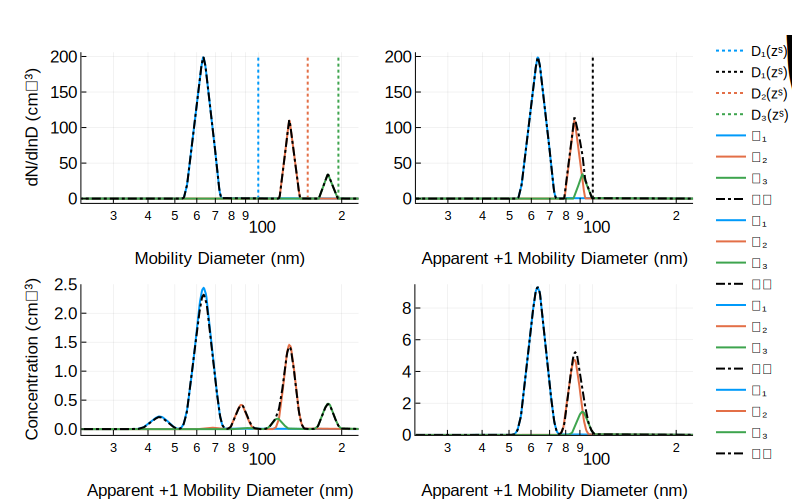

In [6]:
# Setup the special case
Dm = 100                 # Dry size 100 nm
zˢ = dtoz(Λ₁, Dm*1e-9);  # Compute corresponding electrical mobility
n = 3                    # Charges 1..3

figure("Nimbus Sans L", 2, 5.5, 3.5, 8)
p = Plots.get_color_palette(:auto, default(:bgcolor), 100) # Get a list of colors from the theme palette

# Panel 1: m\Mobility diameter
𝕩 = map(k -> Nkz(zˢ,k,Λ₁,δ₁), 1:3)
𝕪 = Nz(zˢ,Λ₁,δ₁)
p1 = plot([ztod(Λ₁,1,zˢ), ztod(Λ₁,1,zˢ)], [0,200], color = p[1], ls = :dot, label = "D₁(zˢ)", lw = 2)
p1 = plot!([ztod(Λ₁,2,zˢ), ztod(Λ₁,2,zˢ)], [0,200], color = p[2], ls = :dot, label = "D₂(zˢ)", lw = 2)
p1 = plot!([ztod(Λ₁,3,zˢ), ztod(Λ₁,3,zˢ)], [0,200], color = p[3], ls = :dot, label = "D₃(zˢ)", lw = 2)
p1 = plot!(𝕩[1].Dp, 𝕩[1].S, label = "ℕ₁<sup>δ₁</sup>", xaxis = :log10, xlim = (50,500), color = p[1])
p1 = plot!(𝕩[2].Dp, 𝕩[2].S, label = "ℕ₂<sup>δ₁</sup>", color = p[2])
p1 = plot!(𝕩[3].Dp, 𝕩[3].S, label = "ℕ₃<sup>δ₁</sup>", color = p[3])
p1 = plot!(𝕪.Dp, 𝕪.S, color = :black, label = "𝕟ₜ<sup>δ₁</sup>", ls = :dashdot, lw = 1.25, 
    ylabel = "dN/dlnD (cm⁻³)", left_margin = 20px, xlabel = "Mobility Diameter (nm)")

# Panel 2: Apparent +1 Mobility diameter
𝕩 = map(k -> Nkm(zˢ,k,Λ₁,δ₁), 1:3)
𝕪 = Nm(zˢ,Λ₁,δ₁)
p2 = plot([ztod(Λ₁,1,zˢ), ztod(Λ₁,1,zˢ)], [0,200], color = :black, ls = :dot, label = "D₁(zˢ)", lw = 2)
p2 = plot!(𝕩[1].Dp, 𝕩[1].S, xlim = (120, 220), label = "𝕄₁<sup>δ₁</sup>", color = p[1])
p2 = plot!(𝕩[2].Dp, 𝕩[2].S, label = "𝕄₂<sup>δ₁</sup>", color = p[2])
p2 = plot!(𝕩[3].Dp, 𝕩[3].S, label = "𝕄₃<sup>δ₁</sup>", color = p[3])
p2 = plot!(𝕪.Dp, 𝕪.S, color = :black, lw = 1.25, ls = :dashdot,
     label = "𝕞ₜ<sup>δ₁</sup>", xlabel = "Apparent +1 Mobility Diameter (nm)")

# Panel 3: Passage through DMA
𝕩 = map(k -> δ₂.𝐀*Nkz(zˢ,k,Λ₁,δ₁), 1:3)
𝕪 = δ₂.𝐀*Nz(zˢ,Λ₁,δ₁)
p3 = plot(𝕩[1].Dp, 𝕩[1].N, label = "ℕ₁<sup>δ₂</sup>")
p3 = plot!(𝕩[2].Dp, 𝕩[2].N, label = "ℕ₂<sup>δ₂</sup>")
p3 = plot!(𝕩[3].Dp, 𝕩[3].N, label = "ℕ₃<sup>δ₂</sup>")
p3 = plot!(𝕪.Dp, 𝕪.N, xaxis = :log10,  ylim = (-0.1,2.5), xlim = (50,500), color = :black, ls = :dashdot,
            left_margin = 34px, lw = 1.25, label = "𝕟ₜ<sup>δ₂</sup>",
            ylabel = "Concentration (cm⁻³)", xlabel = "Apparent +1 Mobility Diameter (nm)")

# Panel 4: Passage through DMA
𝕩 = map(k -> δ₂.𝐎*Nkm(zˢ,k,Λ₁,δ₁), 1:3)
𝕪 = δ₂.𝐎*Nm(zˢ,Λ₁,δ₁)
p4 = plot(𝕩[1].Dp, 𝕩[1].N, label = "𝕄₁<sup>δ₂</sup>")
p4 = plot!(𝕩[2].Dp, 𝕩[2].N, label = "𝕄₂<sup>δ₂</sup>")
p4 = plot!(𝕩[3].Dp, 𝕩[3].N, label = "𝕄₃<sup>δ₂</sup>")
p4 = plot!(𝕪.Dp, 𝕪.N, xlim = (120,220), xlabel = "Apparent +1 Mobility Diameter (nm)", lw = 1.25, 
    ls = :dashdot, color = :black, left_margin = 30px, ylim = (0,9.5), label = "𝕞ₜ<sup>δ₂</sup>")

plot(p1,p2,p3,p4, layout = grid(2,2), legend=:right, xlim = (23,230),
     xaxis = :log10, top_margin = 35px, right_margin = 20px, lw = 2,
     bottom_margin = 20px, fmt = :svg)

__Figure 2.__ _Top left_. Evaporated mobility size distribution with +1 (blue), +2 (orange), and +3 (green) charges graphed at their physical diameter. Vertical dotted lines give the selected diameter by DMA1. The black dashdotted line gives the total distribution evaluated using the expression ∑[EF$.⋅$(Tᵢ$.*$𝕟ᶜⁿ)]. _Top right_. Apparent +1 mobility selected size. Blue, organge and green correspond to +1, +2, and +3 charges. Vertical dotted line is the selected mobility diameter by DMA1. Dashed line corresponds to the sum of the three evaluated with expression ∑[(dᵢ/d₁)$⋅$(EF$.⋅$(Tᵢ$.*$𝕟ᶜⁿ)))]. _Bottom left_. Same as top left after passage through a charge neutralizer and DMA2. Colors indicate the size distribution of +1 (blue), +2 (orange), and +3 (green) charges exiting DMA2. _Bottom right_. Apparent +1 mobility size distribution from panel above after passage through DMA2 without charge neutralization. Colors indicate the size distribution of +1 (blue), +2 (orange), and +3 (green) charges exiting DMA2. 

## Summary and Conclusions
Distributions arising in TDMA applications can be modeled using a combination of size distribution arithmetic (Notebook S3, S8). The five key expressions are 

```julia
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp) # Transfer model through DMA
Nkz = (zˢ,k,Λ,δ) -> EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ)  # Size distribution for particles with charge k
Nz = (zˢ,Λ,δ) -> Σ(k->EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ),Λ₁.n) # Total size distribution for all charges 1..n
Nkm = (zˢ,k,Λ,δ) -> ((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))) # App Mobility dist k charges
Nm =(zˢ,Λ,δ) -> Σ(k->((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(EF⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))),Λ₁.n); # Total all charges
```
where T describes the transfer through the DMA, Nk describe the mobility size distribution for mobility selection Zs and k charges, Nz is the mobility size distribution for all charges, Nkm is the apparent +1 mobility distribution for mobility selection Zs and k charges, and Nm is the mobility distribution for all charges. The response function after DMA is obtained using the above expression and the convolution matrices (Notebook S2). The evaporation factor varies with size. The example in Figure 2 demonstrates how the differential evaporation leads to separation of the different sizes when using a second neutralizer. In fact, Wright et al. (2016) used a second neutralization step to track the evaporation of +2 and +1 charged particles independently.  

## References

Bilde, M., Svenningsson, B., Mønster, J., and Rosenørn, T. (2003). Even−Odd Alternation of Evaporation Rates and Vapor Pressures of C3−C9 Dicarboxylic Acid Aerosols. Environ. Sci. Technol., 37(7):1371–1378, DOI:10.1021/es0201810.

Park, K., D. Dutcher, M. Emery, J. Pagels, H. Sakurai, J. Scheckman, S. Qian, M. R. Stolzenburg, X. Wang, J. Yang & P. H. McMurry (2008) Tandem Measurements of Aerosol Properties—A Review of Mobility Techniques with Extensions, Aerosol Science and Technology, 42:10, 801-816, DOI:10.1080/02786820802339561.

Rader, D.J. and P.H. McMurry (1986) Application of the tandem differential mobility analyzer to studies of droplet growth or evaporation,Journal of Aerosol Science, 17(5), 771-787,DOI:10.1016/0021-8502(86)90031-5.

Wright, T. P., C. Song, S. Sears & M. D. Petters (2016) Thermodynamic and kinetic behavior of glycerol aerosol, Aerosol Science and Technology, 50:12, 1385-1396, DOI: 10.1080/02786826.2016.1245405.

Xue, H., Moyle, A. M., Magee, N., Harrington, J. Y., and Lamb, D. (2005), Experimental Studies of Droplet Evaporation Kinetics: Validation of Models for Binary and Ternary Aqueous Solutions. J. Atmos. Sci., 62(12):4310–4326, DOI:10.1175/JAS3623.1.